<a href="https://colab.research.google.com/github/diaboloshogunate/GoogleColabML/blob/main/MNIST-k-means-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.optimize import linear_sum_assignment as linear_assignment

In [139]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

In [140]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [141]:
def train(model, train_loader, num_epochs=5, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [142]:
def get_feature_vectors(model, testloader):
    for i, data in enumerate(testloader):
        img, _ = data
        feature_vector = (model.encoder(img).reshape(len(img), 64)).detach().numpy()
        if i == 0:
            vectors = feature_vector
        else:
            vectors = np.concatenate((vectors, feature_vector), axis=0)
    return vectors

In [144]:
max_epochs = 1
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)
model = Autoencoder()
outputs = train(model, num_epochs=max_epochs, train_loader=train_loader)

Epoch:1, Loss:0.0112


In [145]:
features = get_feature_vectors(model, train_loader)

In [146]:
kmeans = KMeans(init="random", n_clusters=10, n_init=4, random_state=0)
kmeans.fit(features)

KMeans(init='random', n_clusters=10, n_init=4, random_state=0)

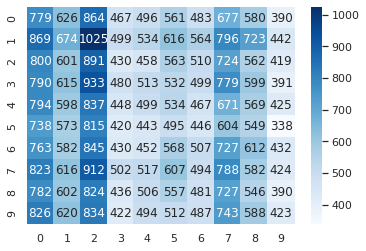

In [147]:
cm = confusion_matrix(train_loader.dataset.targets, kmeans.labels_)
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

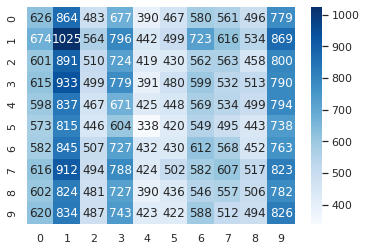

In [148]:
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

_, col_ind = linear_assignment(_make_cost_m(cm))
cm2 = cm[:, col_ind]
ax = sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")

In [149]:
np.trace(cm2) / np.sum(cm)

0.1056